# Country scale coastal change and exposure analysis

* **Products used:** [DE Africa Coastlines](https://docs.digitalearthafrica.org/en/latest/data_specs/Coastlines_specs.html)



## Background

The coastal environment is highly dynamic, undergoing changes influenced by tidal, seasonal, and climatic factors, as well as human activities. 
A significant percentage of Africa's population reside in coastal areas. As population growth continues and coastal cities expand rapidly, mapping and improving our understanding of coastal regions are becoming increasingly important.

Remote sensing data plays a crucial role in generating various types of information products, ranging from local to regional scales, to support effective coastal management. These information products enable:
* Classification and monitoring of coastal geomorphology, such as beaches, cliffs, estuaries, and vegetation cover. 
* Assessment of vegetation and habitat health, providing insights into the wellbeing of important ecosystems such as mangroves and salt marshes. 
* Monitoring of erosion and accretion rates, helping to identify areas prone to erosion and understand the processes driving coastal changes.
* Mapping of human settlements along the coast, facilitating an understanding of population distribution and density.
* Mapping of coastal topography, including elevation and slope.

The DE Africa platform offers access to diverse datasets and information products at a continental scale. These datasets can be integrated to gain insights into the current state of the coastal environment and its temporal changes. This information empowers countries and local authorities to take proactive measures against climate change and make informed decisions regarding coastal management.

## Description

This notebook demonstrates how a user can leverage the DE Africa Coastlines service and other datasets accessible through the platform to understand trends of coastal change and its potential impact for a African country.

The analysis covered include:
* Retrieve and extract DE Africa Coastlines rates of change dataset over a country of interest
* Summarise and visualize the overall trends of change
* Inspect trends of change for selected administration areas in a country
* Combine coastline change information with gridded population data and topographic information to estimate exposure


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
import numpy as np
from matplotlib import pyplot as plt

import datacube
from deafrica_tools.spatial import xr_rasterize, xr_vectorize

## Retrieve coastlines rates of change over a country of interest

The DE Africa Coastlines is a continental coastline monitoring service that can be accessed directly from AWS S3 bucket or OGC Web Services.
The [Coastlines dataset notebook](../../Datasets/Coastlines.ipynb) demonstrates loading DE Africa Coastlines over a small area through the Web Feature Service (WFS). 
For country scale analysis in this notebook, we will access data directly from AWS S3.

We will retrieve the `rates_of_change` layer from the geopackage hosted in AWS and load the data into a `geopandas.GeoDataFrame`.
To save memory, we will extract data over a specified country using the `country` attribute in the dataset.
This attribute was set based on intersection of a coastal location with the exclusive economic zone boundaries defined in https://deafrica-input-datasets.s3.af-south-1.amazonaws.com/deafrica-coastlines/countries_eez_deafrica.geojson
Therefore, we have to pick a country name from the names used in this boundary file. 

> If a different administrative boundary definition is desired, the entire continental dataset can be loaded and a spatial join with a user defined boundary geometry can be run.

In [2]:
# list of country names used
countries_gdf = gpd.read_file("https://deafrica-input-datasets.s3.af-south-1.amazonaws.com/deafrica-coastlines/countries_eez_deafrica.geojson")
countries = list(countries_gdf["TERRITORY1"].values)
print(countries)

['Nigeria', 'Seychelles', 'Gabon', 'Sao Tome and Principe', 'Senegal', 'Guinea-Bissau', 'Mauritania', 'Sudan', 'Togo', 'Cape Verde', 'Kenya', 'Angola', 'Federal Republic of Somalia', 'Algeria', 'South Africa', 'Djibouti', 'Ivory Coast', 'Tanzania', 'Sierra Leone', 'Tunisia', 'Republic of Mauritius', 'Eritrea', 'Morocco', 'Comores', 'Guinea', 'Mozambique', 'Liberia', 'Republic of the Congo', 'Benin', 'Namibia', 'Egypt', 'Madagascar', 'Gambia', 'Ghana', 'Libya', 'Cameroon', 'Democratic Republic of the Congo', 'Equatorial Guinea']


As an example, `Nigeria` will be used. For a different country, the name can be copied from the list above.

In [3]:
country = "Nigeria"

The following step takes a few minutes to run because the continental dataset is retrieved first before a country subset is extracted and saved in the `coastlines` variable. 

In [4]:
%%time
rates_of_change = gpd.read_file("https://deafrica-services.s3.af-south-1.amazonaws.com/coastlines/v0.4.2/deafricacoastlines_v0.4.2.gpkg", 
                           layer="rates_of_change").query(f"country == '{country}'")

CPU times: user 1min 2s, sys: 3.12 s, total: 1min 5s
Wall time: 3min 26s


The Coastlines `rates_of_change` dataset includes a list of attributes, for which detailed explanations can be found in the relevant section in the [User Guide](https://docs.digitalearthafrica.org/en/latest/data_specs/Coastlines_specs.html#Rate-of-Change-Statistics).

In [5]:
rates_of_change.head()

,uid,rate_time,sig_time,se_time,outl_time,dist_2000,dist_2001,dist_2002,dist_2003,dist_2004,...,angle_std,valid_obs,valid_span,sce,nsm,max_year,min_year,country,certainty,geometry
1372535,s11urfuqr7,-0.25,0.042,0.12,2007,7.58,7.58,7.07,8.63,6.75,...,7,23,24,20.36,-7.58,2006,2018,Nigeria,good,POINT (270901.008 813330.134)
1372536,s11urfuwtd,-0.20,0.101,0.11,2007,5.04,4.90,5.34,8.21,6.95,...,5,23,24,18.34,-5.04,2006,2018,Nigeria,good,POINT (270926.941 813334.497)
1372537,s11urfuygs,-0.21,0.176,0.15,2007,7.42,6.18,6.88,9.13,9.01,...,4,23,24,23.46,-7.42,2006,2018,Nigeria,good,POINT (270952.518 813341.7)
1372538,s11urfvp1c,-0.26,0.149,0.17,2007,7.81,6.67,5.55,4.73,8.25,...,4,23,24,26.96,-7.81,2006,2018,Nigeria,good,POINT (270978.337 813344.843)
1372539,s11urfvr24,-0.37,0.102,0.21,2007,11.16,10.45,8.03,4.52,11.36,...,4,23,24,31.09,-11.16,2006,2011,Nigeria,good,POINT (271003.807 813350.802)


## Summarise and visualize the overall trends of change

Not all shorelines and coastal changes can be mapped accurately with Earth observation data and the method implemented by the DE Africa Coastlines service due to the limited number of historical observations available, presence of cloud cover, and the complex nature of shoreline morphology.

We will select only data points where the `certainty` attribute has a value of `good` to be used in further analysis.
Each `good` rates of change were calculated from at least 15 valid annual shoreline location measurements. Other `certainty` attribute values that indicate unreliable measurments are explained in the [user guide](https://docs.digitalearthafrica.org/en/latest/data_specs/Coastlines_specs.html).

In [6]:
# each measurement is made over a 30 m segment along the shoreline
total_shoreline = len(rates_of_change)
print(f"A total of {round(total_shoreline*30/1000)} km of shoreline was mapped for {country}")

A total of 1795 km of shoreline was mapped for Nigeria


In [7]:
good_rates = rates_of_change[rates_of_change.certainty=='good']

n_good = len(good_rates)
perc_good = n_good*100./total_shoreline
print(f"{round(perc_good)}% or {round(n_good*30/1000)} km of shoreline had good rates of change measurements")

88% or 1585 km of shoreline had good rates of change measurements


We can inspect the distributions of the `good` measurements and the significant changes.
Significant changes have a significance (p-value) of less than 0.01, which indicates a shoreline is measured to have undergone consistent change through time.

In [8]:
sig_rates = good_rates[(good_rates.sig_time<0.01)]

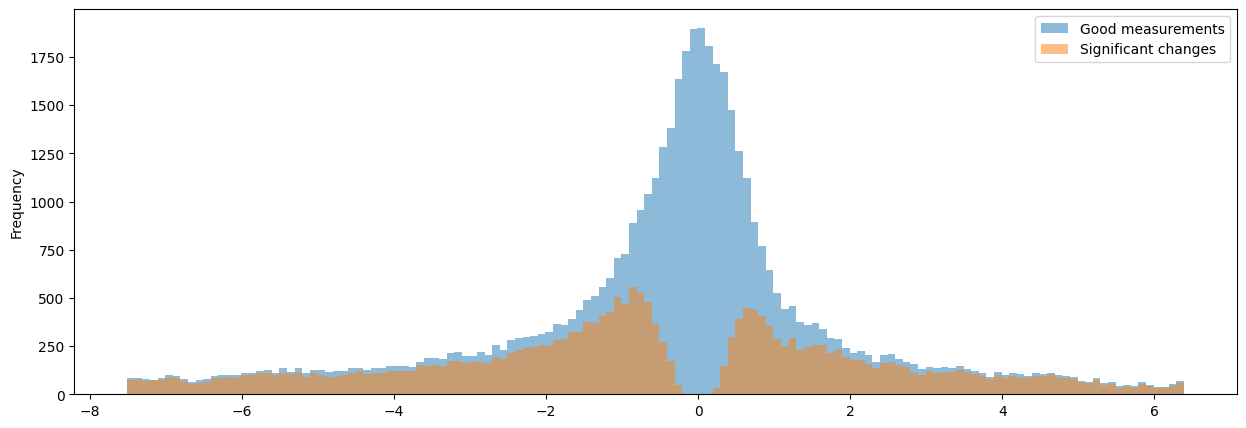

In [9]:
low, high = list(good_rates.rate_time.quantile([0.05,0.95]))
bins = np.arange(low,high,0.1)
good_rates.rate_time.plot.hist(alpha=0.5, bins=bins, label='Good measurements', legend=True, figsize=(15,5));
sig_rates.rate_time.plot.hist(alpha=0.5, bins=bins, label='Significant changes', legend=True);

> It is likely that both erosion and accretion have happened along a country's shoreline. Significant changes at a rate of more than a few metres per year, both retreating and advancing, have been observed in many African countries.

### Change statistics

A number of summary statistics of coastline change can be calculated.

#### The length and percentage of shorelines that have been moving at a rate of more than 0.5 metre per year since 2000.

In [10]:
total = good_rates.rate_time.count()*30/1000
km_neg05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5)).sum()*30/1000
km_pos05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time>0.5)).sum()*30/1000
km_no = total - km_neg05 - km_pos05

print(f"{round(km_neg05)} km of shorelines retreated at more than 0.5 metre per year")
print(f"{round(km_pos05)} km of shorelines advanced at more than 0.5 metre per year")
print(f"{round(km_no)} km of shorelines without significant movement measured")

452 km of shorelines retreated at more than 0.5 metre per year
330 km of shorelines advanced at more than 0.5 metre per year
803 km of shorelines without significant movement measured


#### Alternatively, we can calculate the corresponding percentage of shorelines relative to the total length of shoreline with good measurements.

In [11]:
total = good_rates.rate_time.count()
perc_neg05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5)).sum()*100/total
perc_pos05 = ((good_rates.sig_time<0.01) & (good_rates.rate_time>0.5)).sum()*100/total
perc_no = 100. - perc_neg05 - perc_pos05

print(f"{round(perc_neg05)}% of shorelines retreated at more than 0.5 metre per year")
print(f"{round(perc_pos05)}% of shorelines advanced at more than 0.5 metre per year")
print(f"{round(perc_no)}% of shorelines without significant movement measured")

29% of shorelines retreated at more than 0.5 metre per year
21% of shorelines advanced at more than 0.5 metre per year
51% of shorelines without significant movement measured


## Inspect trends of change for selected administration areas in a country

In this example, we use the administration boundary information from the Database of Global Administrative Areas (GADM) dataset (version 4.1).
The coastlines change statistics will be summarised over the provinces (level-1 admin boundaries).

GADM for other countries can be download from https://gadm.org/download_country.html

In [12]:
gadm_level1 = gpd.read_file("data/gadm41_NGA_1.json.zip")
gadm_level1 = gadm_level1.to_crs(rates_of_change.crs)

In [13]:
gadm_level1.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,NGA.1_1,NGA,Nigeria,Abia,NA,NA,State,State,NA,NG.AB,NG-AB,"MULTIPOLYGON (((720057.812 634765.479, 720038...."
1,NGA.2_1,NGA,Nigeria,Adamawa,NA,NA,State,State,NA,NG.AD,NG-AD,"MULTIPOLYGON (((1182024.473 1039167.332, 11812..."
2,NGA.3_1,NGA,Nigeria,AkwaIbom,NA,NA,State,State,NA,NG.AK,NG-AK,"MULTIPOLYGON (((802727.257 580831.425, 802563...."
3,NGA.4_1,NGA,Nigeria,Anambra,NA,NA,State,State,NA,NG.AN,NG-AN,"MULTIPOLYGON (((669209.543 746057.689, 669257...."
4,NGA.5_1,NGA,Nigeria,Bauchi,NA,NA,State,State,NA,NG.BA,NG-BA,"MULTIPOLYGON (((941001.745 1219245.892, 939332..."


The change data points will be assigned the nearest province labels and a maximum distance of 1km is imposed.

> Data points without a matching province will be discarded.

In [14]:
good_rates = good_rates.sjoin_nearest(gadm_level1[["GID_0", "GID_1", "NAME_1","geometry"]], how="inner", max_distance=1000)
good_rates = good_rates.drop(columns=["index_right"])

The changes will be summarised for each province.

In [15]:
countries_summary = pd.DataFrame(list(good_rates.NAME_1.unique()), columns=["Region"])
countries_summary[['perc_neg05', 'perc_no', 'perc_pos05', 'km_neg05', 'km_no', 'km_pos05']] = [np.nan]*6

for idx in countries_summary.index:
    good_rates_area = good_rates[good_rates[f"NAME_1"]==countries_summary.loc[idx][f"Region"]]
    if len(good_rates_area)==0:
        print("no data over", countries_summary.loc[idx][f"Region"])
        continue

    # get stats
    total = len(good_rates_area)
    perc_neg05 = ((good_rates_area.sig_time<0.01) & (good_rates_area.rate_time<-0.5)).sum()*100/total
    perc_pos05 = ((good_rates_area.sig_time<0.01) & (good_rates_area.rate_time>0.5)).sum()*100/total
    perc_no = 100. - perc_neg05 - perc_pos05
      
    total_km = total*30/1000
    km_neg05 = ((good_rates_area.sig_time<0.01) & (good_rates_area.rate_time<-0.5)).sum()*30/1000
    km_pos05 = ((good_rates_area.sig_time<0.01) & (good_rates_area.rate_time>0.5)).sum()*30/1000
    km_no = total_km - km_neg05 - km_pos05

    for cname in ['perc_neg05', 'perc_no', 'perc_pos05', 'km_neg05', 'km_no', 'km_pos05']:
        countries_summary.at[idx, cname] = eval(cname)

### Visualise the change summary

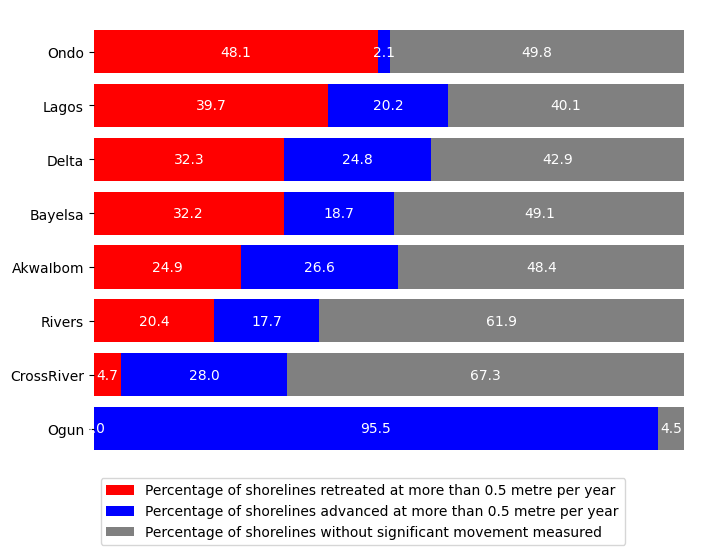

In [16]:
countries_sorted = countries_summary.sort_values(by='perc_neg05')

countries = list(countries_sorted.Region)
neg_data = list(countries_sorted.perc_neg05)
pos_data = list(countries_sorted.perc_pos05)
non_data = list(countries_sorted.perc_no)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,6))

# Plot the stacked horizontal bars
neg_bars = ax.barh(indices, neg_data, color=colors[0], label='Percentage of shorelines retreated at more than 0.5 metre per year ')
pos_bars = ax.barh(indices, pos_data, left=neg_data, color=colors[1], label='Percentage of shorelines advanced at more than 0.5 metre per year')
non_bars = ax.barh(indices, non_data, left=np.add(neg_data, pos_data), color=colors[2], label='Percentage of shorelines without significant movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the center of each colored bar segment
for bars in [neg_bars, pos_bars, non_bars]:
    for bar in bars:
        width = bar.get_width()
        x_center = bar.get_x() + bar.get_width() / 2
        y_center = bar.get_y() + bar.get_height() / 2
        ax.text(x_center, y_center, str(round(width,1)), ha='center', va='center', color='white')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='upper left', bbox_to_anchor=(0, 0), ncol=1);

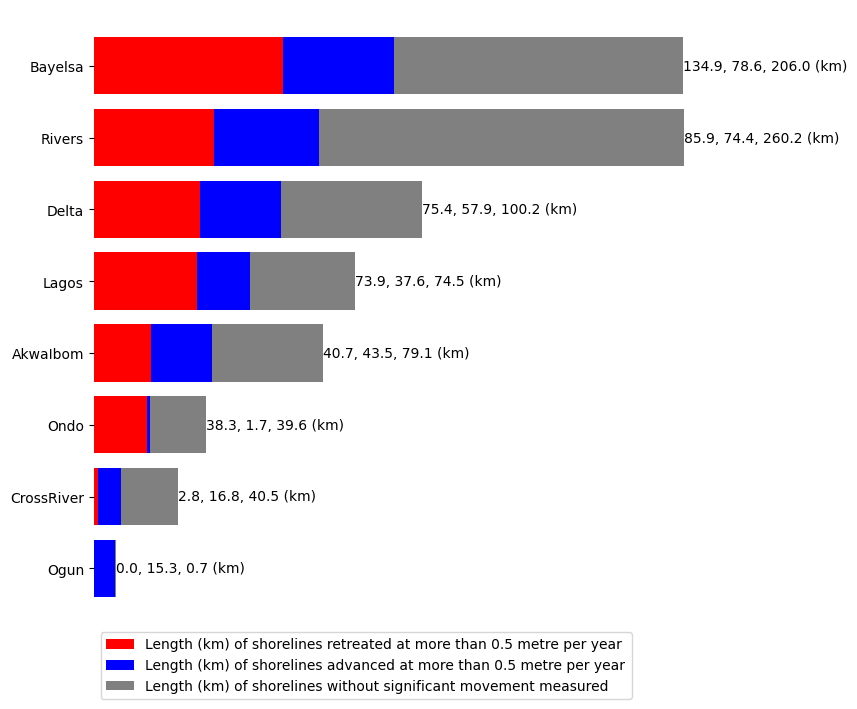

In [17]:
countries_sorted = countries_summary.sort_values(by='km_neg05')

countries = list(countries_sorted.Region)
neg_data = list(countries_sorted.km_neg05)
pos_data = list(countries_sorted.km_pos05)
non_data = list(countries_sorted.km_no)

# Set the color scheme for the segments
colors = ['red', 'blue', 'grey']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,8))

# Plot the stacked horizontal bars
neg_bars = ax.barh(indices, neg_data, color=colors[0], label='Length (km) of shorelines retreated at more than 0.5 metre per year ')
pos_bars = ax.barh(indices, pos_data, left=neg_data, color=colors[1], label='Length (km) of shorelines advanced at more than 0.5 metre per year')
non_bars = ax.barh(indices, non_data, left=np.add(neg_data, pos_data), color=colors[2], label='Length (km) of shorelines without significant movement measured')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the right of each bar segment
for i in range(len(countries)):
    total_width = neg_data[i] + pos_data[i] + non_data[i]
    x_center = total_width
    y_center = indices[i]
    ax.text(x_center, y_center, f"{round(neg_data[i],1)}, {round(pos_data[i],1)}, {round(non_data[i],1)} (km)", ha='left', va='center')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='upper left', bbox_to_anchor=(0, 0), ncol=1);

## Combine coastline change information with gridded population data to estimate exposure


We will estimate the following population exposures:
* Population within 1 km of 2021 shoreline
* Population within 1 km of shoreline retreating at more than 0.5 meters per year
* Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters
* Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom)

In [18]:
os.environ['AWS_DEFAULT_REGION']="us-east-1"
os.environ['AWS_S3_ENDPOINT']="s3.us-east-1.amazonaws.com"
# Load population data
ds = rxr.open_rasterio('s3://dataforgood-fb-data/hrsl-cogs/hrsl_general/hrsl_general-latest.vrt', 
                       chunks ={'x': 1000, 'y': 1000})
ds = ds.rename({'x':'longitude','y':'latitude'})

# Load elevation data
dc=datacube.Datacube()
mrvbf = dc.load(product="dem_srtm_deriv", measurements=["mrvbf"], dask_chunks={'longitude':2000, 'latitude':2000}, 
                like=ds.geobox).mrvbf.squeeze()
elev = dc.load(product="dem_srtm", measurements=["elevation"], dask_chunks={'longitude':2000, 'latitude':2000}, 
                like=ds.geobox).elevation.squeeze()

In [19]:
buffered = rates_of_change.copy()
buffer=1000
buffered['geometry'] = buffered.to_crs('6933').buffer(buffer).to_crs(ds.geobox.crs)
coast_bbox = buffered.unary_union.bounds

pop_raster = ds.isel(band=0).sel(longitude=slice(coast_bbox[0],coast_bbox[2]), latitude = slice(coast_bbox[3], coast_bbox[1]))
    
shoreline_mask = xr_rasterize(gdf=buffered,
                                da=pop_raster,
                                crs=pop_raster.geobox.crs)

pop_raster,shoreline_mask = xr.align(pop_raster, shoreline_mask, join='override')

pop_nearshore = (pop_raster*shoreline_mask).sum().compute().data.round().astype(int)
print("Population within 1km of 2021 shoreline:", pop_nearshore)

/tmp/ipykernel_587/974901051.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coast_bbox = buffered.unary_union.bounds


Population within 1km of 2021 shoreline: 1084100


In [20]:
buffered = rates_of_change[(rates_of_change.certainty=='good') & (rates_of_change.sig_time<0.01) & (rates_of_change.rate_time<-0.5)].copy()
buffer=1000
buffered['geometry'] = buffered.to_crs('6933').buffer(buffer).to_crs(ds.geobox.crs)

hotspots_mask = xr_rasterize(gdf=buffered,
                                da=pop_raster,
                                crs=pop_raster.geobox.crs)

pop_raster,hotspots_mask = xr.align(pop_raster, hotspots_mask, join='override')

pop_nearerosion = (pop_raster*hotspots_mask).sum().compute().data.round().astype(int)
print("Population within 1km of shoreline retreating at more than 0.5 meters per year:", pop_nearerosion)

Population within 1km of shoreline retreating at more than 0.5 meters per year: 780443


In [21]:
os.environ['AWS_DEFAULT_REGION']="af-south-1"
os.environ['AWS_S3_ENDPOINT']="s3.af-south-1.amazonaws.com"
elev_mask = elev.sel(longitude=slice(coast_bbox[0],coast_bbox[2]), latitude = slice(coast_bbox[3], coast_bbox[1]))<5

pop_raster,hotspots_mask,elev_mask = xr.align(pop_raster,hotspots_mask,elev_mask , join='override')

pop_lowelev = (pop_raster*hotspots_mask*elev_mask).sum().compute().data.round().astype(int)
print("Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters:", 
      pop_lowelev)

Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters: 261942


In [22]:
mrvbf_mask = mrvbf.sel(longitude=slice(coast_bbox[0],coast_bbox[2]), latitude = slice(coast_bbox[3], coast_bbox[1]))==7

pop_valley = (pop_raster*hotspots_mask*mrvbf_mask).sum().compute().data.round().astype(int)
print("Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom):", 
      pop_valley)

Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom): 195748


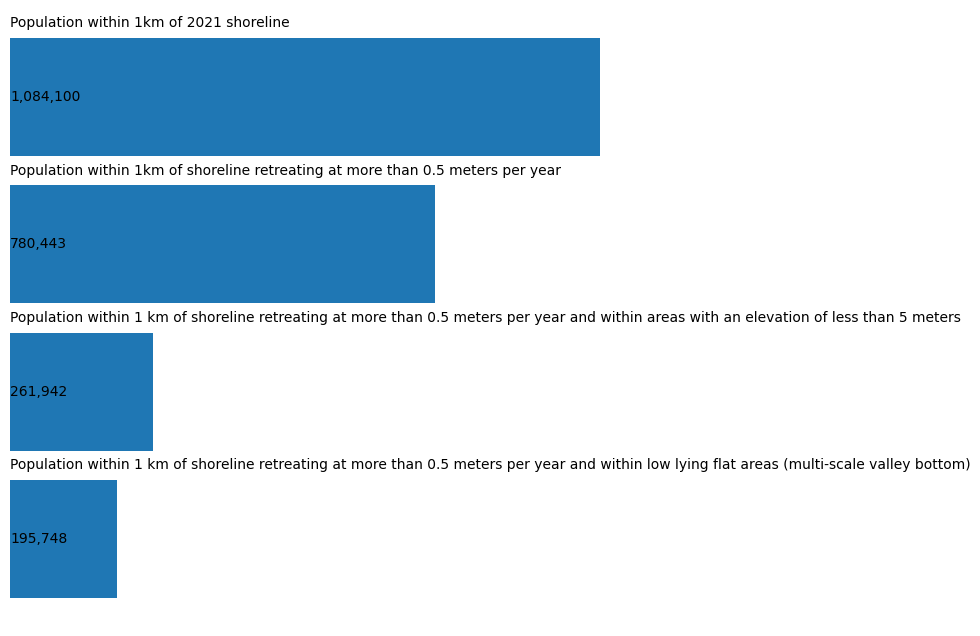

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

categories = ["1", "2", "3", "4"]
labels = ["Population within 1km of 2021 shoreline", 
          "Population within 1km of shoreline retreating at more than 0.5 meters per year",
          "Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters",
          "Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom)"][::-1]
pops = [pop_nearshore, pop_nearerosion, pop_lowelev, pop_valley][::-1]

# Create a horizontal bar chart
plt.barh(categories, pops)

# Add category text above each bar
for i, value in enumerate(labels):
    plt.text(0, i+0.5, str(value), ha='left', va='center')
    plt.text(0, i, f"{pops[i]:,}", ha='left', va='center')


# Set labels and title
plt.ylabel('');
plt.xlabel('');
# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([]);
ax.set_yticks([]);

### Export exposure hotspots

We identify exposure hotspots as population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas.
Coastal erosion results in increased risk of flooding in such areas.

In [24]:
if pop_valley > 0:
    hotspots_map = pop_raster*hotspots_mask*mrvbf_mask
    exposure_vectors = xr_vectorize(hotspots_map, mask=hotspots_map > 0, attribute_col='population', crs='epsg:4326')

exposure_vectors.to_file(f'{country}_hotspots.shp')

The hotspots can be visualized below agained a high resolution basemap.
Alternatively, the exported vector can be downloaded and inspected in desktop GIS.

In [25]:
exposure_vectors.explore(
    column='population',
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [26]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [27]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-05-06'